# Analysis of courier daily activity dataset: Next Day prediction

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Next-Day task consists of predicting the 'courier_partners_online' for the single next day based on the information available for the previous days.
 </p>
</div>

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Import necessary packages</p>
</div>

In [26]:
import pandas as pd
import numpy as np
import os
from scipy import fftpack  # or 'fft'
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from wolt_test_assignment.config import PROCESSED_DATA_DIR, RAW_DATA_DIR
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from datetime import datetime, timedelta
%matplotlib inline

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define utility functions 
 </p>
</div>

In [27]:
def plot_prediction(y_test_original, predicted_courier_number_original, start_date):
    """
    Plot the real and predicted values for courier partners online.

    Parameters:
    y_test_original (array-like): The original test values (real values).
    predicted_courier_number_original (array-like): The predicted values from the model.

    Returns:
    None
    """
    date_range = pd.date_range(start=start_date, periods=len(y_test_original))
    plt.plot(date_range, y_test_original, color='red', marker='+', label="Real")
    plt.plot(date_range, predicted_courier_number_original, color="blue", marker='o', label="Predicted")
    plt.title("Prediction")
    plt.xlabel("Day")
    plt.ylabel("Number of Courier Partners Online")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()


<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Load, clean dataset and define features </p>
</div>

In [28]:
file_name = os.path.join(RAW_DATA_DIR, "daily_cp_activity_dataset.csv")
df_daily_activity = pd.read_csv(file_name)
df_daily_activity['date'] = pd.to_datetime(df_daily_activity['date'])
anomaly_threshold = 500
df_daily_activity_cleaned = df_daily_activity.copy(deep= True)
df_daily_activity_cleaned.loc [df_daily_activity['courier_partners_online']>500, 'courier_partners_online'] = None
df_daily_activity_cleaned = df_daily_activity_cleaned.ffill()

In [29]:

df_daily_activity_cleaned['day_of_week'] = df_daily_activity_cleaned['date'].dt.dayofweek
df_daily_activity_cleaned = pd.get_dummies(df_daily_activity_cleaned, columns=['day_of_week'])

##################################33
# Define a reference date for trend calculation
start_date = df_daily_activity_cleaned['date'].min()
REFERENCE_DATE = start_date 

# Transform the 'date' column
df_daily_activity_cleaned['days_since_start'] = (df_daily_activity_cleaned['date'] - REFERENCE_DATE).dt.days
df_daily_activity_cleaned['day_of_year_sin'] = np.sin(2 * np.pi * df_daily_activity_cleaned['date'].dt.dayofyear / 365)
df_daily_activity_cleaned['day_of_year_cos'] = np.cos(2 * np.pi * df_daily_activity_cleaned['date'].dt.dayofyear / 365)


<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define set of features. Welcome to experiment and select different sets and see what happens with predictions below </p>
</div>

In [30]:
features = ['courier_partners_online', 'precipitation', 'temperature'] + \
    [col for col in df_daily_activity_cleaned.columns if col.startswith('day_of_week')]
# Update the features list to include the new date features'
#print(len(features))

date_features = ['days_since_start', 'day_of_year_sin', 'day_of_year_cos']
#features += date_features

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
  <p> 
    To train, test, and validate the model, we will split the data into training, validation, and testing sets. We will use the first 70% portion of the data for training, the middle portion 10% for validation, and the last 20% portion for testing. 
  </p>
</div>

In [31]:
duration_train = int(0.6*df_daily_activity_cleaned.shape [0])
duration_val = int(0.2*df_daily_activity_cleaned.shape [0])
start_date = (df_daily_activity_cleaned["date"].iloc[0])

# Calculate the validation start date
SPLIT_DATE_TRAIN_END = start_date + timedelta(duration_train)
SPLIT_DATE_TEST = start_date + timedelta(duration_train) + timedelta(duration_val)

SPLIT_DATE_TRAIN_END = SPLIT_DATE_TRAIN_END.strftime("%Y-%m-%d")
SPLIT_DATE_TEST = SPLIT_DATE_TEST.strftime("%Y-%m-%d")

print(SPLIT_DATE_TRAIN_END, SPLIT_DATE_TEST)

SPLIT_DATE_TEST = "2023-01-01"
SPLIT_DATE_TRAIN_END = "2022-10-15"

#SPLIT_DATE_TRAIN_END = "2022-07-31"

2022-07-31 2022-12-30


In [32]:
total_set = df_daily_activity_cleaned[features].values
training_set = df_daily_activity_cleaned[features][df_daily_activity_cleaned['date'] < SPLIT_DATE_TRAIN_END].values

val_set = df_daily_activity_cleaned[(df_daily_activity_cleaned['date'] >= SPLIT_DATE_TRAIN_END) & (df_daily_activity_cleaned['date'] < SPLIT_DATE_TEST)][features].values
test_set = df_daily_activity_cleaned[features][df_daily_activity_cleaned['date'] >= SPLIT_DATE_TEST].values

SC = StandardScaler()

# Fit the scaler on the total set and transform both training and test sets
SC.fit(total_set)
total_set_scaled = SC.transform(total_set)
training_set_scaled = SC.transform(training_set)
test_set_scaled = SC.transform(test_set)
val_set_scaled = SC.transform(val_set)


## LSTM model definition

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define RNN model, namely the Long-Short-Term_Memory multilayer model for time series forecasting
 </p>
</div>

In [33]:
def create_lstm_model(input_shape, n_steps):
    """
    Create and compile an LSTM model with Dropout regularization.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    model (Sequential): Compiled LSTM model.
    """
    regressor = Sequential()

    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    regressor.add(Dropout(0.3))

    # Second LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=80, return_sequences=True))
    regressor.add(Dropout(0.1))

    # Third LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Fourth LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=30))
    regressor.add(Dropout(0.3))

    # Output layer
    regressor.add(Dense(units=n_steps))

    # Compile the model
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    return regressor

In [34]:
# Example usage
input_shape = (40, 10)  # Example input shape (timesteps, features)
n_steps = 1  # Example number of steps to predict
model = create_lstm_model(input_shape, n_steps)
model.summary()

c:\Users\mikes\Documents\STUDY\MLOps\wolt_test_assignment_2025\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 40, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 40, 80)         │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 40, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 40, 50)         │        26,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,271 (540.12 KB)

 Trainable params: 138,271 (540.12 KB)

 Non-trainable params: 0 (0.00 B)

## Predicting courier numnber for the Next-Day task

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Let us perform next-step forecasting to predict courier numbers for the next day.  First, prepare the training, validation and test datasets.
 </p>
</div>

### Analysis with Linear Regression models

In [35]:
# Prepare the training data
training_days = 40  # Number of past days to use for prediction
n_steps = 1  # Number of future steps to predict

In [36]:
# Prepare the train data
X_train = []
y_train = []

for i in range(training_days, len(training_set_scaled) - n_steps + 1):
 
    X_train.append(training_set_scaled[i - training_days:i])
    y_train.append(training_set_scaled[i:i + n_steps, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))

# Prepare the test data
X_test = []
y_test = []
y_test_original = []
for i in range(training_days, len(test_set_scaled) - n_steps + 1):
    #X_test.append(test_set_scaled[i - training_days:i])
    
    y_test_original.append(test_set[i:i + n_steps, 0])
    y_test.append(training_set_scaled[i:i + n_steps, 0])
    X_test.append(test_set_scaled[i - training_days:i].flatten())  # Flatten for MultiOutputRegressor input

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_original = np.array(y_test_original)

split_date_dt = datetime.strptime(SPLIT_DATE_TEST, "%Y-%m-%d")
start_date = split_date_dt + timedelta(training_days)
start_date_str = start_date.strftime("%Y-%m-%d")

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define and train Linear Regression model
 </p>
</div>

In [37]:
if n_steps == 1:
    y_train = y_train.flatten()  # Single-output regression
    model = LinearRegression()
else:
    model = MultiOutputRegressor(LinearRegression())  # Multi-step regression
model.fit(X_train, y_train)

LinearRegression()

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Make prediction for the courier number several day ahead and plot it compared to the real data from the test set
 </p>
</div>

In [38]:
# Make predictions on the test set
predicted_courier_number = model.predict(X_test)
          
# Create a placeholder array for inverse transform
predicted_full = np.zeros((predicted_courier_number.shape[0], training_set_scaled.shape[1]))   
        
predicted_full[:, 0] = predicted_courier_number.flatten()
   
predicted_original = SC.inverse_transform(predicted_full)

# Extract the original scale predictions for 'courier_partners_online'
predicted_courier_number_original = predicted_original[:, 0]
integer_predicted_courier_number = np.round(predicted_courier_number_original)

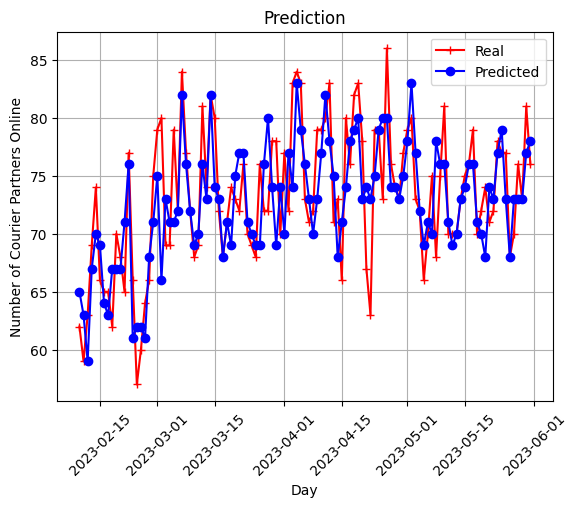

In [39]:
plot_prediction(y_test_original, integer_predicted_courier_number, start_date_str)

### Feature importance analysis for Linear Regression model

In [40]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

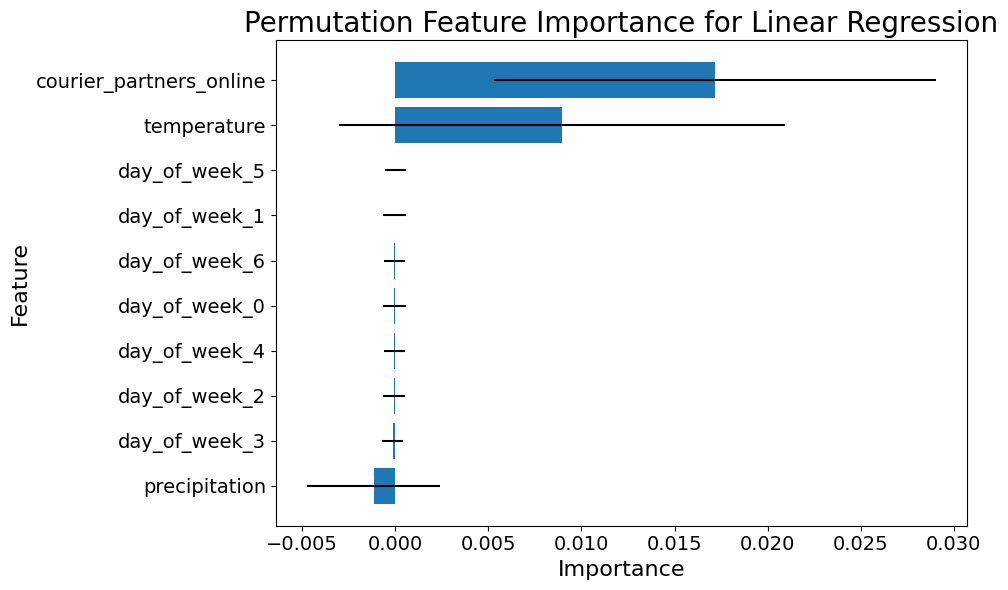

In [41]:
feature_number = len(features)  
feature_names = features

mean_coefs = np.mean( np.reshape(result.importances_mean, (training_days, feature_number) ), axis=0)   
std_coefs = np.mean( np.reshape(result.importances_std, (training_days, feature_number) ), axis=0)   

#mean_coefs = np.reshape(result.importances_mean, (training_days, feature_number) ) [39,:]
#std_coefs = np.reshape(result.importances_std, (training_days, feature_number) ) [39,:]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_coefs,
    'Importance_std': std_coefs
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Importance_std'])
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Permutation Feature Importance for Linear Regression', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Analysis with LSTM model

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Create train, validation and test datasets for LSTM model
 </p>
</div>

In [42]:
# Prepare the training data
X_train = []
y_train = []

for i in range(training_days, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - training_days:i])
    y_train.append(training_set_scaled[i, 0])  # Only 'courier_partners_online' as target

X_train, y_train = np.array(X_train), np.array(y_train)

# Prepare the test set
X_test = []
y_test = []
y_test_original = []

for i in range(training_days, len(test_set_scaled)):
    X_test.append(test_set_scaled[i - training_days:i])
    y_test.append(test_set_scaled[i, 0])  # Only 'courier_partners_online' as target
    y_test_original.append(test_set[i, 0])

# Prepare the validation set
X_val = []
y_val = []

for i in range(training_days, len(val_set_scaled)):
    X_val.append(val_set_scaled[i - training_days:i])
    y_val.append(val_set_scaled[i, 0])  # Only 'courier_partners_online' as target
    
X_test, y_test, y_test_original = np.array(X_test), np.array(y_test), np.array(y_test_original)
X_val, y_val = np.array(X_val), np.array(y_val)

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Train model and plot loss curves
 </p>
</div>

In [43]:
# Train the model and record the history
input_shape = (X_train.shape[1], X_train.shape[2])
regressor = create_lstm_model(input_shape, n_steps=1)
history = regressor.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

c:\Users\mikes\Documents\STUDY\MLOps\wolt_test_assignment_2025\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - loss: 0.6669 - val_loss: 0.2908
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.3544 - val_loss: 0.2989
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.3230 - val_loss: 0.2804
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3266 - val_loss: 0.3146
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.3279 - val_loss: 0.2922
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3716 - val_loss: 0.3104
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.3262 - val_loss: 0.3293
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.3014 - val_loss: 0.2961
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.3112 - val_loss: 0.2987
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.2796 - val_loss: 0.2640
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.2985 - val_loss: 0.1735
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss

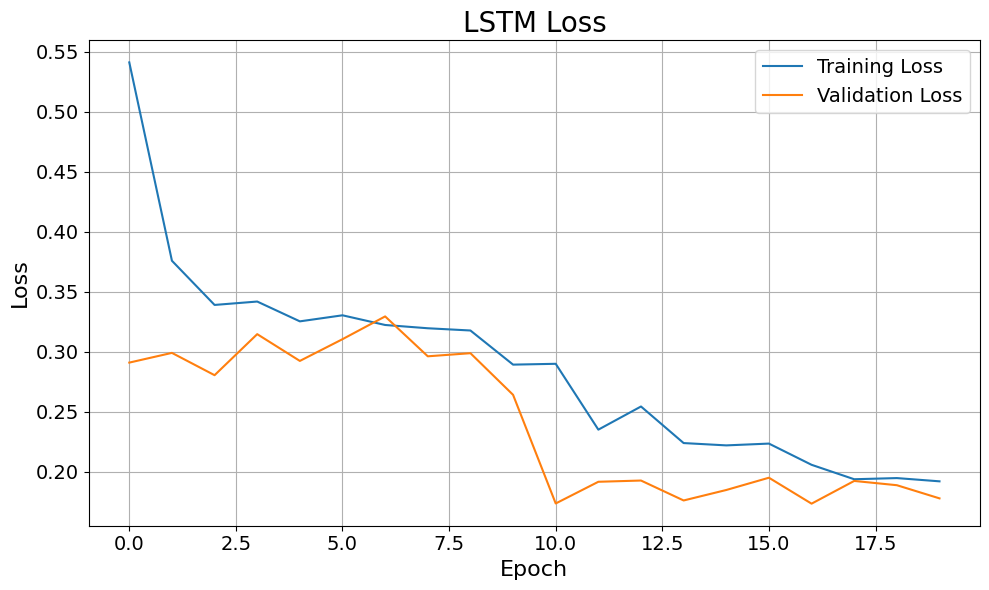

In [44]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid()

# Set font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Predict courier number for a single day ahead and plot it compared to the real data from the test set
 </p>
</div>

In [45]:
# Assuming X_test is prepared similarly to X_train
predicted_courier_number = regressor.predict(X_test)

# Create a placeholder array for inverse transform
# The second dimension should match the number of features (e.g., 2 for 'courier_partners_online' and 'precipitation')
predicted_full = np.zeros((predicted_courier_number.shape[0], total_set.shape[1]))

predicted_full[:, 0] = predicted_courier_number.flatten()

# Debug the placeholder shape
print("Predicted_full shape:", predicted_full.shape)  # Should match the shape required for SC.inverse_transform

# Inverse transform the predictions
predicted_original = SC.inverse_transform(predicted_full)

# Extract the original scale predictions for 'courier_partners_online'
predicted_courier_number_original = predicted_original[:, 0]
integer_predictions= np.round(predicted_courier_number_original).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
Predicted_full shape: (111, 10)


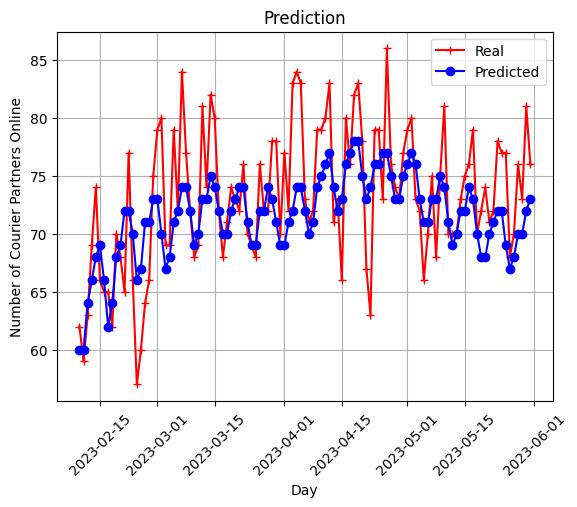

In [46]:
   
# visualize our test and predicted data
plot_prediction(y_test_original, integer_predictions, start_date_str)

## Conclusions

We see that both LSTM models and baseline Linear Regression models can predict  the courier number for the single next day. For this Next-Day prediction task the baseline Linear Regression LSTM models perform almost similarly. Although LSTM has much more trainable parameters, the amount of training data probably is not sufficient to train it properly.

The quantitative metrics of the prediction accuracy such as Mean Square Error (MSE), RMSE, Signal-to-Noise Ratio (SNR) can be calculated using scripts described in README.md